# Libraries

In [34]:
import pandas as pd
import numpy as np

#graph
from matplotlib import pyplot as plt
import seaborn as sns

#modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xml.sax.handler import feature_namespaces #identify feature importance for the dataset

#accuracy and precision
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score



# Cleaning Data 1

Data is obtained from :

https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings?select=Video_Games_Sales_as_at_22_Dec_2016.csv

df column description : 

- id: Game ID on steam platform
- name: Game name as appears on Steam platform
- year: Release year
- metacritic_rating: Metacritic rating (the larger the better)
- reviewer_rating: Game rating given by users on the 0-10 scale (the larger the better)
- positivity_ratio: Number of positive reviews divided by the number of negative reviews
- to_beat_main: Time required to beat the main plot of the game
- to_beat_extra: Time required to beat the main and optional objectives of the game
- to_beat_completionist: Time required to complete every single objective of the game including gathering all collectibles
- extra_content_length: The difference between completionist time and extra time


In [35]:
df = pd.read_csv('dataset/dataset.csv')
df.head()

,id,name,year,metacritic_rating,reviewer_rating,positivity_ratio,to_beat_main,to_beat_extra,to_beat_completionist,extra_content_length,tags
0,96000,The Tiny Bang Story,2011.0,63.0,8.0,7.073879,3.60,3.60,3.77,0.17,Story Rich|Steampunk|Adventure|Atmospheric|Puz...
1,262410,World of Guns: Gun Disassembly,2014.0,NaN,8.0,5.208940,2.00,NaN,28.07,26.07,Horror|First-Person|Historical|Multiplayer|Str...
2,1250410,Microsoft Flight Simulator 40th Anniversary Ed...,2020.0,91.0,6.0,3.581082,NaN,NaN,NaN,NaN,Multiplayer|Adventure|VR|Action Roguelike|Phys...
3,365450,Hacknet,2015.0,82.0,8.0,14.548520,7.06,8.73,10.75,3.69,Horror|Story Rich|Hacking|Crime|Multiplayer|Dy...
4,92800,SpaceChem,2011.0,84.0,8.0,11.440415,43.32,57.79,67.55,24.23,Automation|Strategy|Building|Puzzle|Science|Pr...


lets look at the null vales

In [36]:
df.isna().sum() / len(df) *100

id                        0.000000
name                      0.000000
year                      0.157374
metacritic_rating        93.837244
reviewer_rating          29.765670
positivity_ratio          3.167934
to_beat_main             71.985899
to_beat_extra            78.869427
to_beat_completionist    74.763546
extra_content_length     66.665093
tags                      0.000000
dtype: float64

we have to drop the metacritic_rating column as 93% of values are null. 

I will consider keeping the other columns for the moment.

In [37]:
df = df.drop(['metacritic_rating', 'year', 'id'], axis=1)

# Cleaning Data 2

Data is obtained from :

https://www.kaggle.com/code/gruffgemini/basic-video-game-recommender-system/input

score column definitions:


- Name: Name of the game
- Platform: Console on which the game is running
- Year_of_Release: Year of the game released
- Genre: Game's category
- Publisher: Publisher
- NA_Sales: Game sales in North America (in millions of units)
- EU_Sales: Game sales in the European Union (in millions of units)
- JP_Sales: Game sales in Japan (in millions of units)
- Other_Sales: Game sales in the rest of the world, i.e. Africa, Asia excluding Japan, Australia, Europe excluding the E.U. and South America (in millions of units)
- Global_Sales: Total sales in the world (in millions of units)
- Critic_Score: Aggregate score compiled by Metacritic staff
- Critic_Count: The number of critics used in coming up with the Critic_score
- User_Score: Score by Metacritic's subscribers
- User_Count: Number of users who gave the user_score
- Developer: Party responsible for creating the game
- Rating: The ESRB ratings (E.g. Everyone, Teen, Adults Only..etc)


In [38]:
score = pd.read_csv('dataset/Video_Games_Sales_as_at_22_Dec_2016.csv')

In [39]:
score.isna().sum() / len(score) *100

Name                0.011962
Platform            0.000000
Year_of_Release     1.608948
Genre               0.011962
Publisher           0.322986
NA_Sales            0.000000
EU_Sales            0.000000
JP_Sales            0.000000
Other_Sales         0.000000
Global_Sales        0.000000
Critic_Score       51.330821
Critic_Count       51.330821
User_Score         40.098092
User_Count         54.602548
Developer          39.613613
Rating             40.486871
dtype: float64

we can take down all of unrelevant data, and keep the columns which are only related to game content and components and not sales.

In [40]:
score = score.drop(['JP_Sales','NA_Sales','EU_Sales','Other_Sales','Global_Sales','Critic_Count','User_Count','Rating','Platform','Developer'], axis=1)

#we need the columns in the 2 datasets to have the same format
score.columns  = score.columns.str.lower()

# Question: we want to predict what is the score users will rate the game based on the genre / category of the game, scores from popular gaming sites.

# Merge - Let's Begin the Cleaning

Merge the 2 data sets

In [41]:
data = pd.merge(df, score, on='name')
data.head()

,name,reviewer_rating,positivity_ratio,to_beat_main,to_beat_extra,to_beat_completionist,extra_content_length,tags,year_of_release,genre,publisher,critic_score,user_score
0,Europa Universalis III Complete,8.0,5.188742,NaN,NaN,NaN,NaN,4X|Historical|Multiplayer|Strategy|Grand Strat...,2008.0,Strategy,Paradox Interactive,NaN,8.7
1,The Space Bar,NaN,1.000000,NaN,NaN,NaN,NaN,Noir|Aliens|First-Person|Funny|Crime|Cyberpunk...,1996.0,Adventure,Sega,NaN,NaN
2,Malice,4.0,0.276504,5.50,NaN,NaN,-5.5,Horror|First-Person|Escape Room|Atmospheric|Ex...,2004.0,Platform,Evolved Games,51.0,tbd
3,Malice,4.0,0.276504,5.50,NaN,NaN,-5.5,Horror|First-Person|Escape Room|Atmospheric|Ex...,2004.0,Platform,Evolved Games,48.0,tbd
4,Puzzler World,8.0,7.883721,7.43,17.44,22.03,14.6,Touch-Friendly|Puzzle|Casual|Word Game|Logic|S...,2009.0,Puzzle,Ubisoft,NaN,tbd


We have to extract the information from the column 'tags' to get all of the categories / keywords assigned to the game. 

In [42]:
# we remove the seperators
data['tags'] = data['tags'].str.split('|')
data = data.explode('tags') #explode is used to replicate the rows that have an array / list on the column with individual values

In [43]:
data.head()

,name,reviewer_rating,positivity_ratio,to_beat_main,to_beat_extra,to_beat_completionist,extra_content_length,tags,year_of_release,genre,publisher,critic_score,user_score
0,Europa Universalis III Complete,8.0,5.188742,NaN,NaN,NaN,NaN,4X,2008.0,Strategy,Paradox Interactive,NaN,8.7
0,Europa Universalis III Complete,8.0,5.188742,NaN,NaN,NaN,NaN,Historical,2008.0,Strategy,Paradox Interactive,NaN,8.7
0,Europa Universalis III Complete,8.0,5.188742,NaN,NaN,NaN,NaN,Multiplayer,2008.0,Strategy,Paradox Interactive,NaN,8.7
0,Europa Universalis III Complete,8.0,5.188742,NaN,NaN,NaN,NaN,Strategy,2008.0,Strategy,Paradox Interactive,NaN,8.7
0,Europa Universalis III Complete,8.0,5.188742,NaN,NaN,NaN,NaN,Grand Strategy,2008.0,Strategy,Paradox Interactive,NaN,8.7


Check data format and transform accordingly

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18360 entries, 0 to 1125
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   18360 non-null  object 
 1   reviewer_rating        18030 non-null  float64
 2   positivity_ratio       18285 non-null  float64
 3   to_beat_main           17550 non-null  float64
 4   to_beat_extra          16555 non-null  float64
 5   to_beat_completionist  16476 non-null  float64
 6   extra_content_length   17742 non-null  float64
 7   tags                   18360 non-null  object 
 8   year_of_release        18088 non-null  float64
 9   genre                  18360 non-null  object 
 10  publisher              18306 non-null  object 
 11  critic_score           14323 non-null  float64
 12  user_score             15741 non-null  object 
dtypes: float64(8), object(5)
memory usage: 2.0+ MB


'user_score' should be considered a numerical value

In [45]:
# i identify a non-numerical value in the column 'user_score' and i remove it from the datset
data['user_score'] = data['user_score'].replace('tbd', None)

In [46]:
#user score is a number that ranges from 0 to 10
data['user_score'] = data['user_score'].astype(float)

#should date be considered a categorical value?
#data['year'] = data['year'].astype(object)
#data['year_of_release'] = data['year_of_release'].astype(object)

### Drop Null values

In [47]:
data.isna().sum()

name                        0
reviewer_rating           330
positivity_ratio           75
to_beat_main              810
to_beat_extra            1805
to_beat_completionist    1884
extra_content_length      618
tags                        0
year_of_release           272
genre                       0
publisher                  54
critic_score             4037
user_score               3671
dtype: int64

In [48]:
data = data.dropna()

## classify year of release 

In [49]:
data.year_of_release.unique()

array([2012., 2013., 2011., 2016., 2014., 2009., 2008., 2004., 1998.,
       1999., 2015., 2003., 2010., 2001., 2002., 2006., 1997., 2005.,
       1996., 2007., 2000., 1985.])

In [50]:
data["year_of_release"] = data["year_of_release"].astype(int)

def fix_year (x):

    if x <2000: return "90s"
    elif x>1999 and x<2010: return "00s"
    else: return "10s"

data["epoque"] = data["year_of_release"].apply(lambda x: fix_year(x))



In [51]:
data = data.drop('year_of_release', axis=1)

In [52]:
#data.to_csv('data_merged_final.csv')

# Cateforicals & Numericals - Preparing for training

### Numericals

In [53]:
num = data.select_dtypes([np.number])

Check correlation

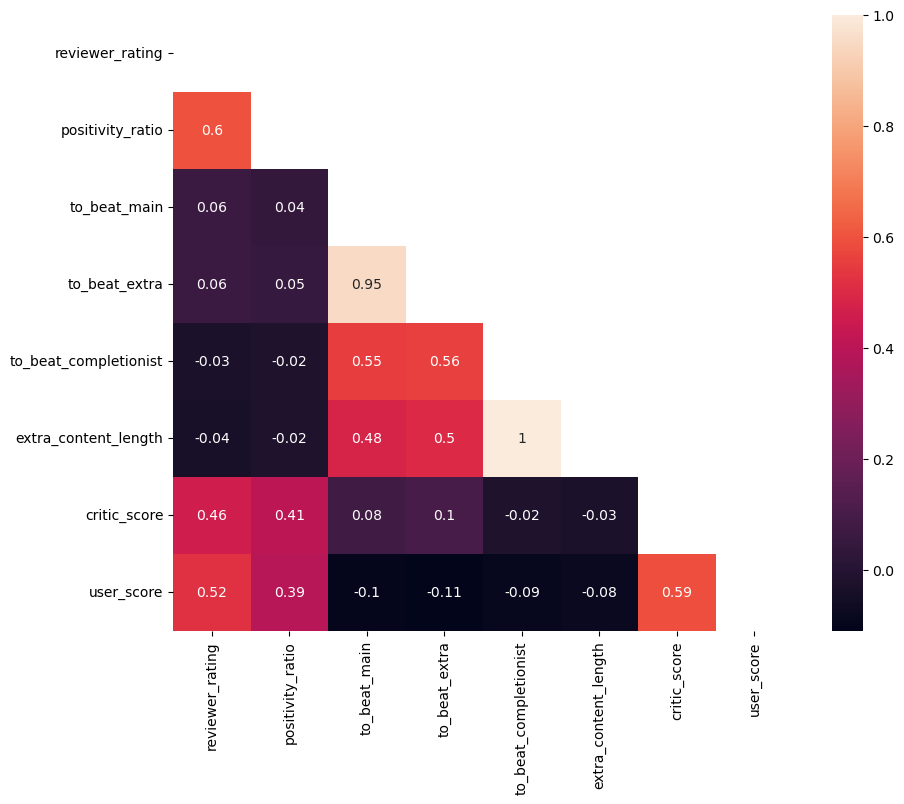

In [54]:
#select numerical data and see relationship between features
correlations_matrix = num.corr().round(2)

#hide half the map
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True 

#choose size of graph
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)

plt.show()

we can perceive there is no strong correlation betweent the columns, we do not have to drop any of the features

transformer = MinMaxScaler().fit(num)
data_norm = transformer.transform(num)
data_norm = pd.DataFrame(data_norm, columns=num.columns)

### Categoricals

In [55]:
cat = data.select_dtypes(np.object_)


In [56]:
cat_encoded = pd.get_dummies(cat, columns=cat.columns)

In [57]:
cat_encoded

,name_15 Days,name_7 Days to Die,name_7 Wonders of the Ancient World,name_A Boy and His Blob,name_A Vampyre Story,name_Advent Rising,name_Aegis of Earth: Protonovus Assault,name_Air Conflicts: Secret Wars,name_Alan Wake,name_Alice: Madness Returns,...,publisher_Virgin Interactive,publisher_Vivendi Games,publisher_Wargaming.net,publisher_Warner Bros. Interactive Entertainment,publisher_Yacht Club Games,publisher_Zoo Digital Publishing,publisher_bitComposer Games,epoque_00s,epoque_10s,epoque_90s
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1124,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1124,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1124,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# X - Y Split

Merge the Data after encoding and scaling

In [58]:
data = pd.concat([num, cat_encoded], axis=1)

## Let's train and predict!

In [59]:
X = data.drop(['user_score'], axis=1)
y = data['user_score']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [61]:
#Linear model
lm = LinearRegression() # start the model object {'coef': []}
lm.fit(X,y)

predictions = lm.predict(X) 
rmse = mean_squared_error(y, predictions, squared=False) 
mae = mean_absolute_error(y, predictions)

print("R2_score:", round(lm.score(X,y),2)) 
print("RMSE:", round(rmse),2)
print("MAE:", round(mae),2)

R2_score: 0.91
RMSE: 0 2
MAE: 0 2


In [63]:
#Random Forest model

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("R2_score:", round(rf_model.score(X,y),2)) 
print("RMSE:", round(rmse),2)
print("MAE:", round(mae),2)

R2_score: 0.98
RMSE: 0 2
MAE: 0 2


### Conclusion:

The RandomForest model is a better with a R2 score of 0.96 for predicting the user_score based on the data provided (scores from other magazines, time of completion and categories / genres games)

## Feature importance

In [ ]:

# Get feature importances
from xml.sax.handler import feature_namespaces


feature_importance_scores = rf_model.feature_importances_

# Create a list of (feature_name, importance_score) pairs
feature_importances = list(zip(data.columns, feature_importance_scores))

# Sort the feature importances in descending order based on importance score
sorted_feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Print the most important features and their corresponding importance scores
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

positivity_ratio: 0.2927785883451353
critic_score: 0.25208031041077644
publisher_bitComposer Games: 0.07442940192130357
name_Stranger of Sword City: 0.03702721234361878
extra_content_length: 0.03354877852363825
publisher_Daedalic Entertainment: 0.031621080169639326
to_beat_extra: 0.026740339094647698
to_beat_completionist: 0.026054029581008
to_beat_main: 0.02395307496256194
name_Company of Heroes: 0.0177316489092353
name_Disney Universe: 0.01503637322651407
name_Quake 4: 0.01194316911022226
epoque_00s: 0.007933751144575807
publisher_Tecmo Koei: 0.007421270718044571
name_Operation Abyss: New Tokyo Legacy: 0.006037329508975115
publisher_BAM! Entertainment: 0.005506294604278487
name_NBA 2K17: 0.00536262505650826
name_F1 2011: 0.004599012747903579
publisher_2D Boy: 0.004227384000421274
genre_Action: 0.0040557124422886635
name_Dishonored: 0.0037691331129677164
name_World of Goo: 0.0037590977358866328
name_Resident Evil 5: 0.0031517107033827187
genre_Role-Playing: 0.0025900105265960587
name_

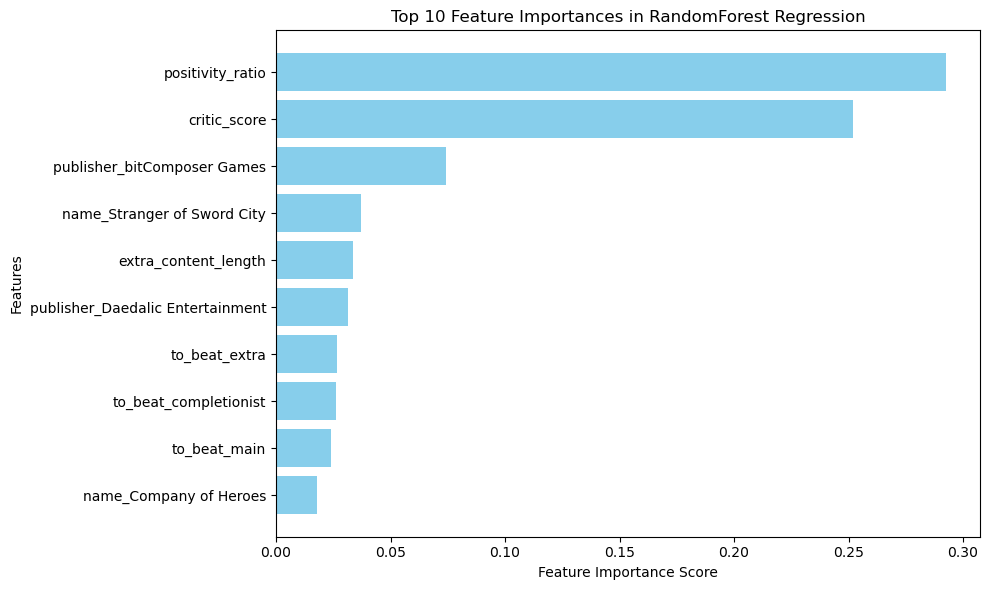

In [ ]:
# Assuming you have already obtained the sorted_feature_importances as shown in the previous example
top_features = sorted_feature_importances[:10]  # Select the top 10 features

# Extract the names and importance scores of the top 10 features
top_feature_names = [feature[0] for feature in top_features]
top_importance_scores = [feature[1] for feature in top_features]

# Create a bar plot for the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_feature_names)), top_importance_scores, align='center', color='skyblue')
plt.yticks(range(len(top_feature_names)), top_feature_names)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances in RandomForest Regression')
plt.gca().invert_yaxis()  # Invert the y-axis to show the highest importance at the top
plt.tight_layout()

plt.show()
